# Budowa modelu z wykorzystaniem SVM do zadania klasyfikacji binarnej
Na początek wczytam dane z pliku csv, które nie są jeszcze podzielone na dane wejściowe i wyjściowe.
Stworzę również funkcję, która z DataFrame, który uzyskałem poprzez wczytanie pliku, przetworzy mi te dane na listę wektorów cech (dane wejściowe) oraz listę danych wyjściowych (aplikacja darmowa lub płatna)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
apps_data = pd.read_csv("./raw_data/apps_data_complete.csv")


def vectorize_series(series):
    vector = []
    for item in series:
        vector.append(item)
    return vector


def transform_data(df):
    in_data = []
    out_data = []
    for item in df.iterrows():
        vectorized_data = vectorize_series(item[1])
        feature_vector = vectorized_data[:-1]
        out_value = int(vectorized_data[-1])
        in_data.append(feature_vector)
        out_data.append(out_value)
    return np.array(in_data), np.array(out_data)


### Podział zbioru na dane wejściowe i wyjściowe oraz na dane treningowe i testowe
Podział na dane treningowe i testowe powinien nastąpić w taki sposób, aby danych treningowych było więcej niż testowych.
Jest to jedyna reguła, jeżeli chodzi o dokładny stosunek, to ciężko stwierdzić, jaki jest najlepszy, popularnym rozwiązaniem jest podział 70%:30% lub 80%:20%, natomiast ja stworzę funkcję, która stosunek będzie przyjmowała jako parametr, dzięki temu będę mógł spróbować różnych rozwiązań.


**Podział na dane wejściowe i wyjściowe**

In [3]:
X, Y = transform_data(apps_data)
print(len(X))
print(len(Y))

143189
143189


**Podział na dane treningowe i testowe**

In [4]:
from sklearn.model_selection import train_test_split


def data_train_test_split(X_in, Y_in, train_size, random_state):
    test_size = 1. - train_size
    X_train, X_test, Y_train, Y_test = train_test_split(X_in, Y_in, train_size=train_size, test_size=test_size,
                                                        shuffle=True, random_state=random_state)
    return X_train, X_test, Y_train, Y_test



X_train, X_test, Y_train, Y_test = data_train_test_split(X, Y, 0.80, 17)

### Analiza podziału danych
Po analizie uważam, że funkcja "train_test_split" dobrze sobie radzi z podziałem danych, na początku myślałem, że problemem będzie to, że w podziale danych na testowe i treningowe, stosunek darmowych aplikacji do płatnych będzie odstawał od stosunku w oryginalnym wektorze, niemniej jednak po podziale, stosunki są bardzo podobne, poniższa komórka to pokazuje.


In [5]:
# Funkcja, która zwraca liczbę darmowych i płatnych aplikacji w liście, która zawiera dane wyjściowe
def get_free_paid_ratio(data_chunk):
    ratio = {
        "free": 0,
        "paid": 0
    }
    for item in data_chunk:
        if item == 1:
            ratio['free'] += 1
        else:
            ratio['paid'] += 1
    return ratio


def present_ratio(title, entry):
    ratio = get_free_paid_ratio(entry)
    free, paid = ratio['free'], ratio['paid']
    whole = free + paid
    free_percent = "{:.4f}% ({})".format((free / whole) * 100, free)
    paid_percent = "{:.4f}% ({})".format((paid / whole) * 100, paid)
    print(f"{title} ratio:\nFree: {free_percent}\nPaid: {paid_percent}")


present_ratio("Y_train", Y_train)
print(f"Y_train size: {len(Y_train)}")
print()
present_ratio("Y_test", Y_test)
print(f"Y_test size: {len(Y_test)}")
print()
present_ratio("Y_main", Y)
print(f"Y_main size: {len(Y)}")

Y_train ratio:
Free: 93.3680% (106954)
Paid: 6.6320% (7597)
Y_train size: 114551

Y_test ratio:
Free: 93.3759% (26741)
Paid: 6.6241% (1897)
Y_test size: 28638

Y_main ratio:
Free: 93.3696% (133695)
Paid: 6.6304% (9494)
Y_main size: 143189


### Przeskalowanie danych
Wektory cech zawierają takie cechy, jak np. installs, które przyjmuje wartości od 0 do 10 miliardów, natomiast cecha, która jest związana z kategorią zawiera się w przedziale (0;1), tak więc koniecznie należy przeskalować dane wejściowe.
Do skalowania danych mam do wyboru dwie metody, *normalizację* oraz *skalowanie min-max*.
W skalowaniu min-max, wartości odstające mogą mieć znaczący wpływ na wynik, tak więc wybieram normalizację, gdyż jest ona mniej wrażliwa na wartości odstające.


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Dopasowanie parametrów skalowania do danych treningowych
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


def compare_after_scaling(before, after, limit=None):
    count = 0
    for item in before:
        print(f"{item} -> {after[count]}")
        count += 1
        if limit is not None and count >= limit:
            break


compare_after_scaling(X_train, X_train_scaled, limit=20)

[5.00000000e+05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.81395809e-02] -> [-0.02223887 -0.92026738 -0.036116   -0.04101203 -0.44692743]
[1.00000000e+05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.69953766e-03] -> [-0.02749833 -0.92026738 -0.036116   -0.04101203 -0.70692974]
[5.00000000e+03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.65725846e-02] -> [-0.02874745 -0.92026738 -0.036116   -0.04101203  0.73703212]
[1.00000000e+05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.53005123e-02] -> [-0.02749833 -0.92026738 -0.036116   -0.04101203  0.08172885]
[1.00000000e+03 4.66666650e+00 1.02000000e+02 5.00000000e+00
 1.81375124e-01] -> [-0.02880005  1.31992131 -0.03599686 -0.04079223  4.5816746 ]
[1.00000000e+05 4.80000000e+00 4.60000000e+02 0.00000000e+00
 3.50495635e-02] -> [-0.02749833  1.38392678 -0.03557871 -0.04101203  0.07399817]
[1.00000000e+04 4.57142900e+00 5.02000000e+02 3.00000000e+00
 4.92057424e-02] -> [-0.02868171  1.27420345 -0.03552965 -0.04088015  0.51009063]

### Utworzenie modelu SVM do zadania klasyfikacji
Na początku utworzę instancję implementacji SVM, tj. SVC w przypadku sklearn, która będzie używała jądra radialnego (RBF) z domyślnymi parametrami, w późniejszym etapie, kiedy będę miał ustaloną metrykę jakości modelu, będę eksperymentował z doborem parametrów, w celu optymalizacji modelu.

In [7]:
from sklearn.svm import SVC

model = SVC(kernel='rbf')

**Pierwsze predykcje modelu**
Załadowanie poniższej komórki zajmuje kilka minut, jest to spowodowane bardzo dużą ilością danych wejściowych.

In [8]:
model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

### Wyznaczenie klasy pozytywnej, negatywnej oraz znaczeń parametrów
Aplikacji płatnych jest o wiele mniej, niż aplikacji darmowych, tak więc prawidłowa predykcja aplikacji płatnej jest więcej warta, niż prawidłowa predykcja aplikacji darmowej, tak więc:
* Aplikacja darmowa (1) - klasa negatywna
* Aplikacja płatna (0) - klasa pozytywna
* TP (True positive) - jeśli model poprawnie przewidzi, że aplikacja jest płatna
* TN (True negative) - jeśli model poprawnie przewidzi, że aplikacja jest darmowa
* FP (False positive) - jeśli model przewidzi, że aplikacja jest płatna, a jest darmowa
* FN (False negative) - jeśli model przewidzi, że aplikacja jest darmowa, a jest płatna

In [9]:
def provide_model_results(preds, values):
    quality_parameters = {
        'TP': 0,
        'TN': 0,
        'FP': 0,
        'FN': 0
    }
    i = 0
    for prediction in preds:
        match prediction, values[i]:
            case (0, 0):
                quality_parameters['TP'] += 1
            case (0, 1):
                quality_parameters['FP'] += 1
            case (1, 0):
                quality_parameters['FN'] += 1
            case (1, 1):
                quality_parameters['TN'] += 1
        i += 1
    return quality_parameters


first_result = provide_model_results(predictions, Y_test)
print(first_result)

{'TP': 249, 'TN': 26633, 'FP': 108, 'FN': 1648}


## Pierwsze spojrzenie na rezultat predykcji modelu
Wyniki modelu dla jądra rbf oraz domyślnych wartości parametrów C=1.0, gamma="scale" wypada dość źle, jeśli chodzi o predykcję aplikacji płatnych, chcę dobrać taką metrykę, aby to zoptymalizować, to jest, zminimalizować liczbę FP oraz liczbę FN.
Metryka, która dopasowuje się do mojego problemu, to F1.
Poniżej znajduje się wizualizacja rezultatów modelu z użyciem macierzy pomyłek.

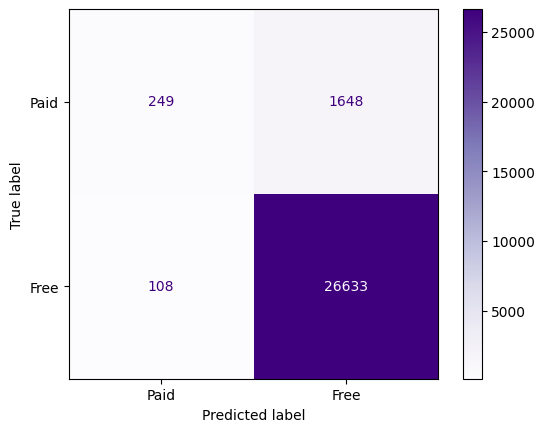

Precision score: 0.6974789915966386
Recall score: 0.1312598840274117
F1 score: 0.2209405501330967


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_test, predictions)
disp =ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Paid', 'Free']
)
disp.plot(cmap="Purples")
plt.savefig("./data_visualization/graphs/confusion_mat.jpg", format="jpg")
plt.show()

def precision(params):
    TP, FP = params['TP'], params['FP']
    return TP/(TP + FP)


def recall(params):
    TP, FN = params['TP'], params['FN']
    return TP/(TP + FN)


def f1_score(params):
    prec, rec = precision(params), recall(params)
    return (2*prec*rec)/(prec + rec)

print(f"Precision score: {precision(first_result)}")
print(f"Recall score: {recall(first_result)}")
print(f"F1 score: {f1_score(first_result)}")

**Metryki**
Jak widać po uruchomieniu ostatniej komórki, jakość modelu jest bardzo różna zależnie od użytej metryki, warto dobrać metrykę, która odpowiada narzuconym kryteriom.

**Ocena jakości**
Tak jak wspomniałem wcześniej, ja będę używał metryki F1, wynik ~0.221 jest tragicznym wynikiem, tak więc będę starał się zoptymalizować model w taki sposób, aby znaleźć parametry, dla których wynik będzie największy.

**Optymalizacja**
Skoro nie mam jawnego wzoru funkcji jakości od parametrów modelu, to nie zastosuję tu metod gradientowych. Zmuszony jestem wykorzystać metody eksploracyjne, w celu poszukiwania wartości parametrów, dla których jakość modelu będzie jak największa.
Zamierzam użyć metody Grid Search, która będzie przeszukiwała siatkę parametrów w celu znalezienia jak najlepszego zestawu rozwiązań.
Zamierzam jednocześnie uruchomić 6 skryptów, każdy z różnym parametrem gamma, dla którego będą szukały rozwiązań dla 200 różnych wartości parametru C.


In [11]:
import re


def extract_score(line):
    pattern = "score: (\S+)"
    match = re.search(pattern, line)
    return float(match.group(1))


def extract_c(line):
    pattern = "C:(\S+)"
    match = re.search(pattern, line)
    return float(match.group(1)[:-1])


def extract_data_from_file(filename):
    with open(filename, "r") as file:
        C = []
        quality = []
        lines = file.readlines()
        for line in lines:
            stripped_line = line.rstrip()
            C.append(extract_c(stripped_line))
            if line[0] == 'f':
                quality.append(0)
            else:
                quality.append(extract_score(stripped_line))
    return C, quality

## Wyniki optymalizacji
Stworzyłem siatkę poszukiwań składającą się z 6 różnych parametrów gamma oraz 200 wartości parametru C.
Poniższe wykresy przedstawiają zależność jakości modelu od wartości parametru C dla ustalonych gamma.

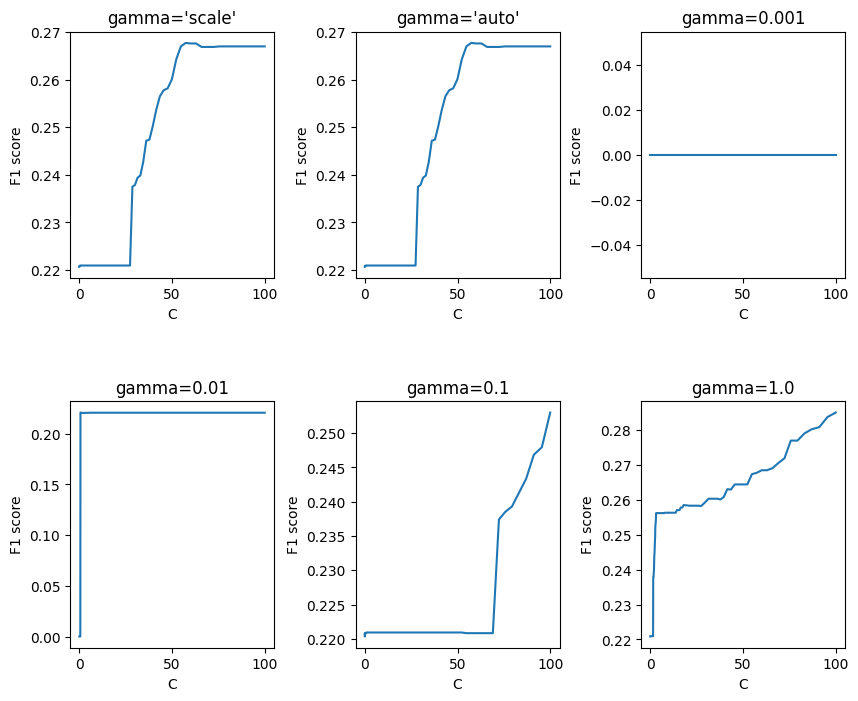

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))
C, quality_scale = extract_data_from_file("./optimizers/data/rbf_scale.txt")
_, quality_auto = extract_data_from_file("./optimizers/data/rbf_auto.txt")
_, quality_0_001 = extract_data_from_file("./optimizers/data/rbf_0.001.txt")
_, quality_0_01 = extract_data_from_file("./optimizers/data/rbf_0.01.txt")
_, quality_0_1 = extract_data_from_file("./optimizers/data/rbf_0.1.txt")
_, quality_1_0 = extract_data_from_file("./optimizers/data/rbf_1.0.txt")
plt.subplots_adjust(wspace=0.4, hspace=0.5)
axes = [axs[0, 0], axs[0, 1], axs[0, 2], axs[1, 0], axs[1, 1], axs[1, 2]]

axes[0].plot(C, quality_scale)
axes[0].set_title("gamma='scale'")

axes[1].plot(C, quality_auto)
axes[1].set_title("gamma='auto'")

axes[2].plot(C, quality_0_001)
axes[2].set_title("gamma=0.001")

axes[3].plot(C, quality_0_01)
axes[3].set_title("gamma=0.01")

axes[4].plot(C, quality_0_1)
axes[4].set_title("gamma=0.1")

axes[5].plot(C, quality_1_0)
axes[5].set_title("gamma=1.0")

for a in axes:
    a.set_xlabel("C")
    a.set_ylabel("F1 score")


fig.savefig("./data_visualization/graphs/optimization_result.jpg", format="jpg")

Najbardziej obiecujące wartości gamma, dla których mogę kontynuować szukanie lepszych wartości jakości modelu, to gamma=0.1 oraz gamma=1.0.
Jako że model jest bardzo wolny, to wybiorę jedną wartość gamma, tj. gamma=1.0 i będę kontynuował optymalizację.

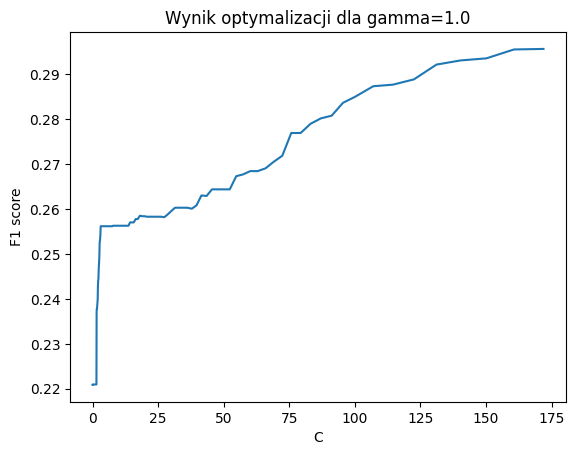

In [12]:
C, quality_1_0 = extract_data_from_file("./optimizers/data/final_data.txt")
plt.plot(C, quality_1_0)
plt.ylabel("F1 score")
plt.xlabel("C")
plt.title("Wynik optymalizacji dla gamma=1.0")
plt.savefig("./data_visualization/graphs/final_optimization.jpg", format='jpg')
plt.show()

## Ostateczny wynik optymalizacji
Najlepszy wynik, jaki udało mi się uzyskać, to F1 score = 0.295687885010267, dla C = 171.90722018585745 oraz gamma = 1.0.
Niemniej jednak dla takich parametrów czas uzyskania predykcji przez model wynosi ponad 1500 sekund!
Najlepszy wynik z o wiele mniejszym czasem predykcji to F1 = 0.2921997523730912 dla C = 131.11339374215643, w dalszej części zajmę się właśnie tym modelem.

In [13]:
final_model = model = SVC(kernel='rbf', C=131.11339374215643, gamma=1.0)
final_model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

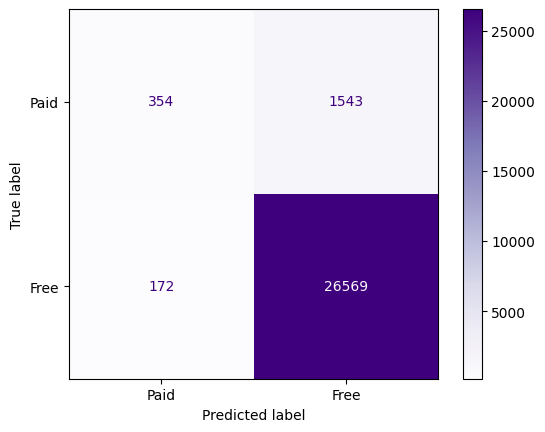

First result: {'TP': 249, 'TN': 26633, 'FP': 108, 'FN': 1648}
Final result: {'TP': 354, 'TN': 26569, 'FP': 172, 'FN': 1543}
First result:
Precision score: 0.6974789915966386
Recall score: 0.1312598840274117
F1 score: 0.2209405501330967
Final result:
Precision score: 0.6730038022813688
Recall score: 0.18661043753294676
F1 score: 0.2921997523730912


In [14]:


cm = confusion_matrix(Y_test, predictions)
disp =ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Paid', 'Free']
)
disp.plot(cmap="Purples")
plt.savefig("./data_visualization/graphs/final_confusion_mat.jpg", format="jpg")
plt.show()


final_result = provide_model_results(predictions, Y_test)

print(f"First result: {first_result}")
print(f"Final result: {final_result}")
print("First result:")
print(f"Precision score: {precision(first_result)}")
print(f"Recall score: {recall(first_result)}")
print(f"F1 score: {f1_score(first_result)}")
print("Final result:")
print(f"Precision score: {precision(final_result)}")
print(f"Recall score: {recall(final_result)}")
print(f"F1 score: {f1_score(final_result)}")

## Ocena optymalizacji
Jak widać, model poprawił swoje zdolności do prawidłowego klasyfikowania aplikacji płatnych oraz zmniejszył ilość pomyłek aplikacji darmowej z płatną.
Ostatecznie, optymalizacja modelu spowodowała **polepszenie jakości modelu o 32.25%**

## Wnioski, przemyślenia
Czy F1 score równy 0.2921997523730912 to dobrze? Nie, to nadal tragiczny wynik.
Czy polepszenie jakości modelu o 32.25% po 30 godzinach optymalizacji to dobrze? Nie, to mało.
Według mnie głównym problemem jest tutaj dobór modelu do ilości danych, pojedyncza iteracja optymalizacji zajmuje zbyt długo, przez co optymalizacja na siatce parametrów wymiaru większego niż 2 mogłaby zająć miesiące.
Ponadto pomiędzy parametrami nie występują trywialne zależności, prawdopodobnie lepiej sprawdziłyby się sieci neuronowe.